# Bilden eines Models mit Original und einem Filter

## Import der notwendigen Pakete

In [1]:
# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## GPU-Test

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))

Num GPUs Available 1


## Helper

In [3]:
model_path = "./keras_alle_filter.hdf5"
import os.path

def isModelAvailable():
    return os.path.isfile(model_path) 

startTraining = True

## Import des Datasets

Zusätzlich zum Laden des Datasets (23 Klassen) wird hier bereits durch den ImageDataGenerator ein Preprocessing durchgeführt / vorbereitet.
Zunächst wird versucht eine Klassifizierung durchzuführen, bei dem die Bilder in Graustufen geladen werden.

In [4]:
# path to dataset
directory = "./FACD_image"
target_size = (224,224)
seed = 42;
batch_size=32

# create a image generator for keras, that can load images batchwise
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

train_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    directory, data_generator, target_size=target_size, color_mode='rgb', class_mode='categorical', 
    batch_size=batch_size, shuffle=True, seed=seed,
    follow_links=False, subset='training', interpolation='nearest', dtype=None
)

test_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    directory, data_generator, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=seed,
    follow_links=False, subset='validation', interpolation='nearest', dtype=None
)

Found 23552 images belonging to 23 classes.
Found 5888 images belonging to 23 classes.


## Erstellen des CNN-Models

In [5]:
input_shape = (224,224,3)
num_classes = 23

metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

model = tf.keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units=128))
model.add(layers.Dense(units=84))
model.add(layers.Dense(num_classes, activation="softmax"))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        3

## Trainieren des Models

Das Warning "This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling" kommt von den nicht gefitteten Bildern des DataGenerators. Normalerweise führt man "data_generator.fit()" vor dem fitten des Modells durch. In der [Doku des DictornaryIterators](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator) steht jedoch, dass das durch das übergebene ImageDateGenerator-Objekt eine Standardisierung und Transformation durchgeführt wird. Aus diesem Grund wird dieses Warning an dieser Stelle ignoriert.

In [6]:
epochs = 20
validation_freq = 1
if not isModelAvailable() or startTraining:
    
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
        min_delta=1e-2,
        patience=2,
        verbose=1)
    
    history = model.fit(
        x=train_iterator, y=None, epochs=epochs, verbose=1, callbacks=[es],
        validation_data=test_iterator, initial_epoch=0, steps_per_epoch=len(train_iterator), validation_freq=validation_freq,
        max_queue_size=10, workers=4
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 736 steps, validate for 184 steps
Epoch 1/20
255/736 [=========>....................] - ETA: 7:23 - loss: 15.4437 - categorical_accuracy: 0.1271 - precision: 0.3079 - recall: 0.0153

C:\Users\Martin\anaconda3\envs\ml\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19273 bytes but only got 816. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Martin\anaconda3\envs\ml\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5140 bytes but only got 816. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Martin\anaconda3\envs\ml\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3144 bytes but only got 816. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


736/736 [==============================] - 406s 551ms/step - loss: 6.9125 - categorical_accuracy: 0.2203 - precision: 0.5553 - recall: 0.0614 - val_loss: 2.1805 - val_categorical_accuracy: 0.3033 - val_precision: 0.7679 - val_recall: 0.1022
Epoch 2/20
736/736 [==============================] - 220s 299ms/step - loss: 1.9500 - categorical_accuracy: 0.3921 - precision: 0.6940 - recall: 0.2041 - val_loss: 1.6401 - val_categorical_accuracy: 0.4764 - val_precision: 0.7898 - val_recall: 0.2502
Epoch 3/20
736/736 [==============================] - 223s 302ms/step - loss: 1.6120 - categorical_accuracy: 0.4882 - precision: 0.7497 - recall: 0.3224 - val_loss: 1.4154 - val_categorical_accuracy: 0.5445 - val_precision: 0.8323 - val_recall: 0.3347
Epoch 4/20
736/736 [==============================] - 223s 303ms/step - loss: 1.5051 - categorical_accuracy: 0.5197 - precision: 0.7508 - recall: 0.3668 - val_loss: 1.3798 - val_categorical_accuracy: 0.5686 - val_precision: 0.8371 - val_recall: 0.3412
Epo

## Speichern des Modells

In [7]:
if not isModelAvailable() or startTraining:
    model.save(
       model_path, overwrite=True, include_optimizer=True, save_format="h5", signatures=None, options=None
    )

## Anzeigen der Lern- und Fehlerkurve

[0.3033288, 0.47639266, 0.5444973, 0.5686141, 0.5725204, 0.5568954, 0.6251698, 0.62788725, 0.63688856, 0.59748644, 0.62941575]


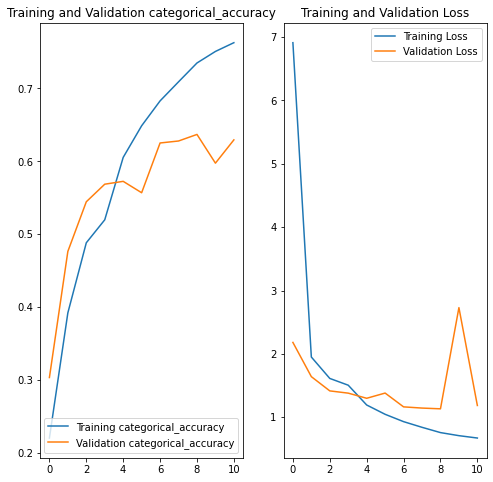

In [10]:
import importlib
import plot #import the module here, so that it can be reloaded.
importlib.reload(plot)

plot.plot_keras_history(history, 11, metrics[0].name)

[0.76785713, 0.7898123, 0.832348, 0.83708334, 0.78246856, 0.7125506, 0.7817179, 0.777288, 0.78073347, 0.7002126, 0.7468624]


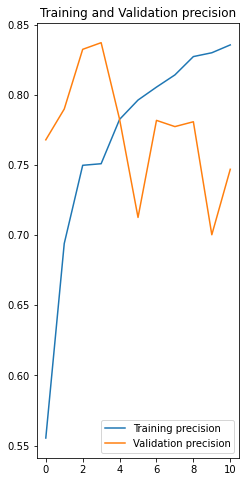

In [11]:
plot.plot_keras_history(history, 11, metrics[1].name)

[0.10224185, 0.25016984, 0.33474866, 0.34120244, 0.41236413, 0.41847825, 0.5054348, 0.5091712, 0.5134171, 0.50339675, 0.53566575]


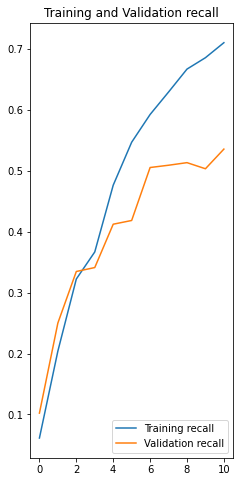

In [12]:
plot.plot_keras_history(history, 11, metrics[2].name)